Project 1: Improving Learning by Optimisation and Regularisation:

In [12]:
# imports

from datetime import datetime

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split
from torchvision import datasets, transforms
import numpy as np
torch.manual_seed(265)
torch.set_default_dtype(torch.double)

Create CIFAR10 Dataset:

In [13]:
split_ratio = 0.9

def load_cifar(train_val_split, data_path='../data/', preprocessor=None):
    if preprocessor is None:
        preprocessor = transforms.Compose([
            transforms.ToTensor(),
            # This normalization data points correspond to the mean & standard deviation for cifar10
            transforms.Normalize((0.4915, 0.4823, 0.4468),
                                 (0.2470, 0.2435, 0.2616))
        ])

    # load datasets
    data_train_val = datasets.CIFAR10(
        data_path,
        train=True,
        download=True,
        transform=preprocessor)

    test_set = datasets.CIFAR10(
        data_path,
        train=False,
        download=True,
        transform=preprocessor)

    # train/validation split
    n_train = int(len(data_train_val) * train_val_split)
    n_val = len(data_train_val) - n_train

    train_set, val_set = random_split(
        data_train_val,
        [n_train, n_val],
        generator=torch.Generator().manual_seed(265)
    )
    return train_set, val_set, test_set


cifar10_train, cifar10_val, cifar10_test = load_cifar(split_ratio)  # contains all elem of cifar dataset


Files already downloaded and verified
Files already downloaded and verified


In [14]:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']

# For each dataset, keep only airplanes and birds
# is now a tuple with only images of birds & planes with their respective label
train_set = [(img, label_map[label]) for img, label in cifar10_train if
             label in [0, 2]]  # stripped down versions of cifar datasets with only birds & planes
val_set = [(img, label_map[label]) for img, label in cifar10_val if
           label in [0, 2]]  # stripped down versions of cifar datasets with only birds & planes
test_set = [(img, label_map[label]) for img, label in cifar10_test if
            label in [0, 2]]  # stripped down versions of cifar datasets with only birds & planes

Define Multilayer Perceptron (MLP):

In [15]:
class MyMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.flat = nn.Flatten()

        self.fc1 = nn.Linear(32 * 32 * 3, 512)
        self.activation1 = nn.ReLU()

        self.fc2 = nn.Linear(512, 256)
        self.activation2 = nn.ReLU()

        self.fc3 = nn.Linear(256, 128)
        self.activation3 = nn.ReLU()

        self.fc4 = nn.Linear(128, 32)
        self.activation4 = nn.ReLU()

        self.fc5 = nn.Linear(32, 2)

    def forward(self, x):
        out = self.flat(x)
        out = self.activation1(self.fc1(out))
        out = self.activation2(self.fc2(out))
        out = self.activation3(self.fc3(out))
        out = self.activation4(self.fc4(out))
        return self.fc5(out)

In [16]:
model = MyMLP()

Training Function:

In [17]:
def train(n_epochs, optimizer, model, loss_fn, train_loader):
    n_batch = len(train_loader)
    losses_train = []
    model.train()
    optimizer.zero_grad(set_to_none=True)

    for epoch in range(1, n_epochs + 1):

        loss_train = 0.0
        for data in train_loader:
            images, labels = data

            images = images.to(device=device)
            labels = labels.to(device=device)

            outputs = model(images)

            loss = loss_fn(outputs, labels)
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()

            loss_train += loss.item()

        losses_train.append(loss_train / n_batch)

        if epoch == 1 or epoch % 10 == 0:
            print('{}  |  Epoch {}  |  Training loss {:.3f}'.format(
                datetime.now().time(), epoch, loss_train / n_batch))
    return losses_train

Manual Training Function:

In [18]:
def train_manual_update(n_epochs, model, loss_fn, train_loader, lr, weight_decay=0., dampening=0., momentum=0.):
    n_batch = len(train_loader)
    losses_train = []
    model.train = []

    v_dic = {name: 0 for name, p in model.named_parameters()}

    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0

        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)

            prediction = model(imgs)
            loss = loss_fn(prediction, labels)
            loss.backward()

            # Optimization part
            with torch.no_grad():  # dont track gradients operations
                for name, p in model.named_parameters():  # Updates the weights and biases
                    v = momentum * v_dic[name] + p.grad + p.data * weight_decay  # Calculates the velocity whilst accounting for weight decay
                    p.data = p.data - v * lr  # Updates the biases and weights with new velocity

                    v_dic[name] = v  # Stores the new velocity
                    p.grad.data.zero_()  # Zeros out the grads

                loss_train += loss.item()
        losses_train.append(loss_train / n_batch)

        if epoch == 1 or epoch % 10 == 0:
            print('{}  |  Epoch {}  |  Training loss {:.3f}'.format(
                datetime.now().time(), epoch, loss_train / n_batch))
    return losses_train

In [37]:
numel_list = [p.numel() for p in model.parameters()]
print("Total number of parameters: ", sum(numel_list))
print("Number of parameter per layer: ", numel_list)

Total number of parameters:  1741794
Number of parameter per layer:  [1572864, 512, 131072, 256, 32768, 128, 4096, 32, 64, 2]


In [38]:
device = (torch.device('cuda') if torch.cuda.is_available()
          else torch.device('cpu'))

epochs = 60
batch_size_global = 512

Training of MLP: Built-in vs Our Manual Implementation

In [21]:
models = []
model_names = []
loss_es_train = []

In [22]:
print(f"Training on function: train() ")
torch.manual_seed(265)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size_global, shuffle=False)
model = MyMLP().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=0., dampening=0., momentum=0.)
loss_fn = nn.CrossEntropyLoss()

loss_tr = train(
    n_epochs=epochs,
    optimizer=optimizer,
    model=model,
    loss_fn=loss_fn,
    train_loader=train_loader,
)

Training on function: train() 
11:37:48.500448  |  Epoch 1  |  Training loss 0.693
11:37:59.106381  |  Epoch 10  |  Training loss 0.685
11:38:10.679832  |  Epoch 20  |  Training loss 0.675
11:38:22.711545  |  Epoch 30  |  Training loss 0.660
11:38:34.220868  |  Epoch 40  |  Training loss 0.637
11:38:45.829142  |  Epoch 50  |  Training loss 0.608
11:38:57.360416  |  Epoch 60  |  Training loss 0.577


In [23]:
print(f"Training on function: train_manual_update() ")
torch.manual_seed(265)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size_global, shuffle=False)
model = MyMLP().to(device=device)
loss_fn = nn.CrossEntropyLoss()

loss_ = train_manual_update(
    n_epochs=epochs,
    model=model,
    loss_fn=loss_fn,
    lr=1e-2,
    train_loader=train_loader,
    weight_decay=0.,
    dampening=0.,
    momentum=0.
)
models.append(model)
model_names.append("Manual_update default values, lr=1e-2, mom=0, w=0.")
loss_es_train.append(loss_)

Training on function: train_manual_update() 
11:38:58.819905  |  Epoch 1  |  Training loss 0.693
11:39:09.590713  |  Epoch 10  |  Training loss 0.685
11:39:21.617097  |  Epoch 20  |  Training loss 0.675
11:39:33.599422  |  Epoch 30  |  Training loss 0.660
11:39:47.515102  |  Epoch 40  |  Training loss 0.637
11:40:01.244655  |  Epoch 50  |  Training loss 0.608
11:40:13.762349  |  Epoch 60  |  Training loss 0.577


In [24]:
print(f"Training on function: train_manual_update() ")
torch.manual_seed(265)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size_global, shuffle=False)
model = MyMLP().to(device=device)
loss_fn = nn.CrossEntropyLoss()

loss_ = train_manual_update(
    n_epochs=epochs,
    model=model,
    loss_fn=loss_fn,
    lr=1e-2,
    train_loader=train_loader,
    weight_decay=1e-5,
    dampening=0.,
    momentum=0.6
)
models.append(model)
model_names.append("Manual_update, lr=1e-2, mom=0.6, w=1e-5")
loss_es_train.append(loss_)

Training on function: train_manual_update() 
11:40:15.136628  |  Epoch 1  |  Training loss 0.693
11:40:26.666782  |  Epoch 10  |  Training loss 0.671
11:40:41.646156  |  Epoch 20  |  Training loss 0.618
11:40:54.807093  |  Epoch 30  |  Training loss 0.540
11:41:10.074873  |  Epoch 40  |  Training loss 0.489
11:41:26.228665  |  Epoch 50  |  Training loss 0.458
11:41:38.323854  |  Epoch 60  |  Training loss 0.432


In [25]:
print(f"Training on function: train_manual_update() ")
torch.manual_seed(265)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size_global, shuffle=False)
model = MyMLP().to(device=device)
loss_fn = nn.CrossEntropyLoss()

loss_ = train_manual_update(
    n_epochs=epochs,
    model=model,
    loss_fn=loss_fn,
    lr=1e-2,
    train_loader=train_loader,
    weight_decay=1e-2,
    dampening=0.,
    momentum=0.66
)
models.append(model)
model_names.append("Manual_update, lr=1e-2, mom=0.66, w=1e-2")
loss_es_train.append(loss_)

Training on function: train_manual_update() 
11:41:39.661945  |  Epoch 1  |  Training loss 0.693
11:41:50.584076  |  Epoch 10  |  Training loss 0.669
11:42:02.891393  |  Epoch 20  |  Training loss 0.605
11:42:17.208846  |  Epoch 30  |  Training loss 0.525
11:42:31.525236  |  Epoch 40  |  Training loss 0.479
11:42:44.019041  |  Epoch 50  |  Training loss 0.450
11:42:56.581853  |  Epoch 60  |  Training loss 0.423


In [26]:
print(f"Training on function: train_manual_update() ")
torch.manual_seed(265)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size_global, shuffle=False)
model = MyMLP().to(device=device)
loss_fn = nn.CrossEntropyLoss()

loss_ = train_manual_update(
    n_epochs=30,
    model=model,
    loss_fn=loss_fn,
    lr=1e-1,
    train_loader=train_loader,
    weight_decay=1e-1,
    dampening=0.,
    momentum=0.8
)
models.append(model)
model_names.append("Manual_update custom, lr=1e-1, mom=0.8, w=1e-1")
loss_es_train.append(loss_)

Training on function: train_manual_update() 
11:42:57.936298  |  Epoch 1  |  Training loss 0.689
11:43:09.376911  |  Epoch 10  |  Training loss 0.531
11:43:22.089842  |  Epoch 20  |  Training loss 0.515
11:43:34.590196  |  Epoch 30  |  Training loss 0.505


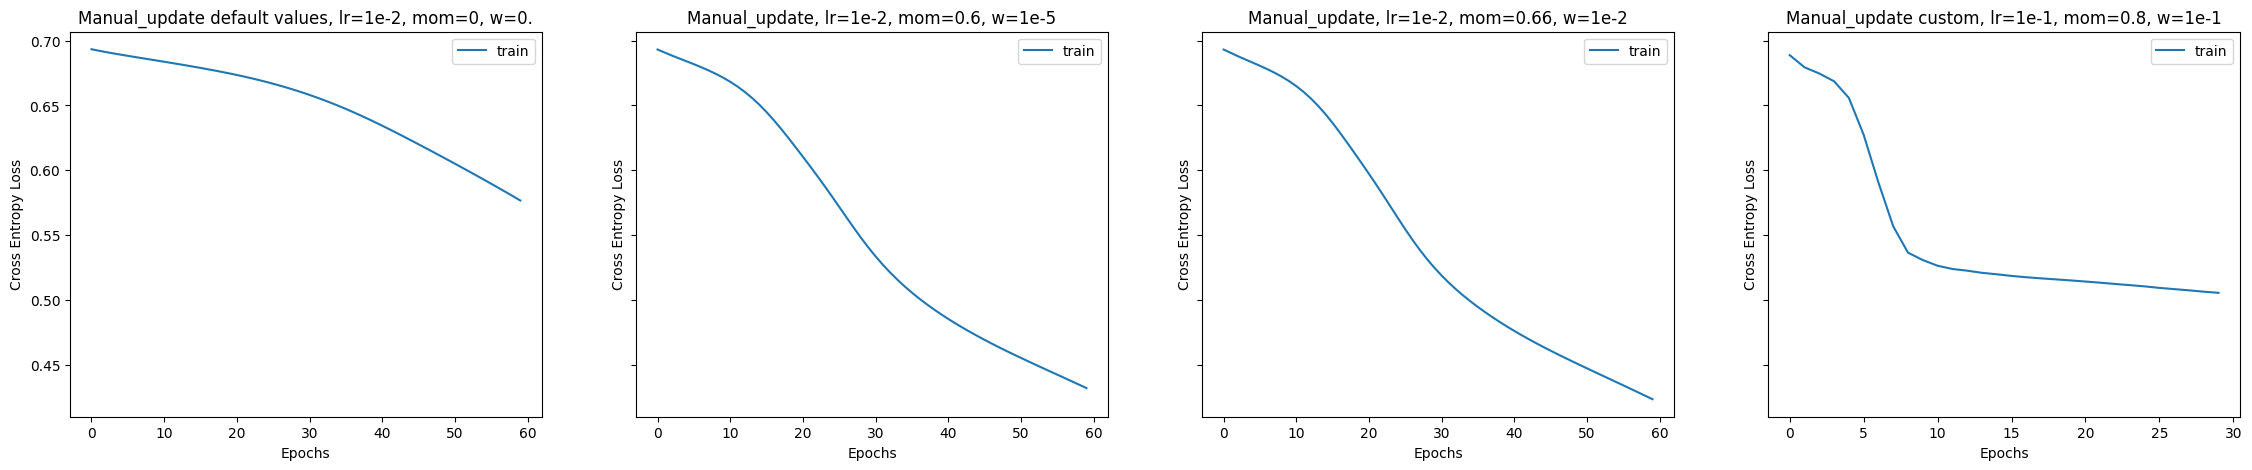

In [27]:
n_model = len(models)

fig, axes = plt.subplots(1, n_model, figsize=(7 * n_model, 5), sharey=True)

for l_train, name, ax in zip(loss_es_train, model_names, axes.flat):
    ax.plot(l_train, label='train')
    ax.set_title(name)
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Cross Entropy Loss')
    ax.legend()

plt.show()

In [32]:
def compute_accuracy(model, loader, name):
    correct = 0.
    total = 0.
    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)

            outputs = model(imgs)
            _, predicted = torch.max(outputs, dim=1)
            total += labels.shape[0]
            correct += int((predicted == labels).sum())

    acc =  (correct / total) * 100


    print(f"Accuracy: {acc :.2f}%, {name}")
    return acc

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size_global, shuffle=False)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size_global, shuffle=False)

accuracies = []
for model, model_nam in zip(models, model_names):
    accuracies.append(compute_accuracy(model, val_loader, model_nam))

i_best_model = np.argmax(accuracies)
best_model = models[i_best_model]
print("\nThe best model is ", model_names[i_best_model])

print("\n")
print("Training accuracy of the best model: ")
compute_accuracy(best_model, train_loader, '')
print("Validation accuracy of the best model: ")
var = compute_accuracy(best_model, val_loader, '')

Accuracy: 75.42%, Manual_update default values, lr=1e-2, mom=0, w=0.
Accuracy: 81.24%, Manual_update, lr=1e-2, mom=0.6, w=1e-5
Accuracy: 81.34%, Manual_update, lr=1e-2, mom=0.66, w=1e-2
Accuracy: 79.17%, Manual_update custom, lr=1e-1, mom=0.8, w=1e-1

The best model is  Manual_update, lr=1e-2, mom=0.66, w=1e-2


Training accuracy of the best model: 
Accuracy: 82.29%, 
Validation accuracy of the best model: 
Accuracy: 81.34%, 


Model performance:

In [33]:
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size_global, shuffle=True)

print(f"The accuracy of the best model is: {compute_accuracy(best_model, test_loader, '') :.2f}%")

Accuracy: 81.90%, 
The accuracy of the best model is: 81.90%
